In [1]:
# Import the necessary library
import time
#import glob
import json
import data_processor as dp
import numpy as np
# import pandas as pd
import h5py
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['text.usetex'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
import seaborn as sns
sns.set(style="white",color_codes=True)
sns.set_context("paper")
%matplotlib inline

Using TensorFlow backend.
C:\Users\melli\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# 5-window scenario attention
import test_model
eval_error_values_norm = test_model.get_evaluation_error('fifo','train','model-weight-a')
eval_error_values_anom = test_model.get_evaluation_error('fifo','anomaly','model-weight-a')
kernel = test_model.kernel(eval_error_values_norm)
init_len = int(len(eval_error_values_norm) * 0.5)
eval_pdf_norm = kernel.pdf(eval_error_values_norm[init_len:])
eval_pdf_anom = kernel.pdf(eval_error_values_anom)

>>> fifo model constructed <<<
>>> fifo model constructed <<<
>>> Initializing with 1682 trace error values <<<
>>> Evaluating with 1683 error values <<<


In [3]:
len(eval_pdf_anom)

1937

In [4]:
# Prepare the data for the KNN
np.random.seed(35)
data_len = int(len(eval_pdf_norm)/2)*2
targets = [0,1]
x_n, x_a = eval_pdf_norm[:data_len].reshape((int(data_len/2), 2)), eval_pdf_anom[:data_len].reshape((int(data_len/2), 2))
y_n, y_a = np.array([targets[0]]*int(data_len/2)), np.array([targets[1]]*int(data_len/2))
X, Y = np.concatenate((x_n,x_a),axis=0), np.concatenate((y_n,y_a),axis=0)
#print(X.shape)
#print(Y.reshape((data_len,1)).shape)
xy = np.hstack((X,Y.reshape((data_len,1))))
np.random.shuffle(xy) 

>>> The optimal number of neighbors is 9


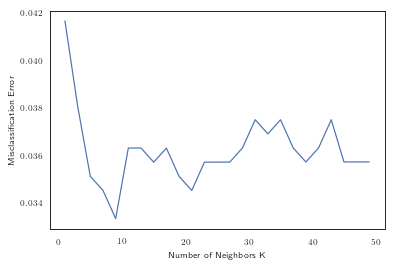

In [5]:
# Find the optimal K to use
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
n_neighbors = [x for x in myList if x % 2 != 0]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in n_neighbors:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=5, n_jobs=-1, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = n_neighbors[MSE.index(min(MSE))]
print(f'>>> The optimal number of neighbors is {optimal_k}')

# plot misclassification error vs k
plt.plot(n_neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [6]:
#cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
#cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
h = .02
n_neighbors = 9
x = xy[:,:-1]
y = xy[:,-1:]
# Create color maps
cmap_light = ListedColormap({'tab:gray', 'tab:blue'})
cmap_bold = ListedColormap({'tab:red','tab:cyan'})
 
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x, y)
 
# calculate min, max and limits
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
#plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
 
# Plot also the training points
#plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=35)
#plt.xlabel('Dimension 1 PDFs Training',fontsize=27)
#plt.ylabel('Dimension 2 PDFs Training',fontsize=27)
#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())
#plt.xticks(fontsize=23)
#plt.yticks(fontsize=23)
    #plt.show()
#plt.savefig('full_.png',orientation='landscape',dpi = 80, papertype = 'legal', format = 'png',
#           facecolor = 'w', edgecolor = 'w', bbox_inches='tight', pad_inches=0.5)
#plt.show()

In [7]:
# generate predictions and test on the fit KNN model
import model
y_pred, y_true = model.inference_attention('fifo','clean')
y_pred_a, y_true_a = model.inference_attention('fifo','anomaly')

>>> Doing inference on: 1286 batches of clean fifo dataset <<<
>>> Doing inference on: 1937 batches of anomaly fifo dataset <<<


In [8]:
# compute the accuracy of the prediction model
y_pred, y_true = np.array(y_pred), np.array(y_true) # normal profile
y_pred_a, y_true_a = np.array(y_pred_a), np.array(y_true_a) 
print(f'>>> Y Pred normal: {y_pred.shape}\t>>> Y True normal: {y_true.shape} <<<')
print(f'>>> Y Pred anomaly: {y_pred_a.shape}\t>>> Y True anomaly: {y_true_a.shape} <<<')

>>> Y Pred normal: (1286, 400, 5)	>>> Y True normal: (1286, 400, 7) <<<
>>> Y Pred anomaly: (1937, 400, 5)	>>> Y True anomaly: (1937, 400, 7) <<<


In [11]:
y_pred, y_true = np.array(y_pred), np.array(y_true) # normal profile
y_pred_a, y_true_a = np.array(y_pred_a), np.array(y_true_a) 

[2, 3, 4]

In [ ]:
# Check for the accuracy of the algorithm
targets = [0,1]
x_n_len = len(x_norm)
x_a_len = len(x_anom)
end_anom = int((x_a_len-data_len)/2)*2
x_n, x_a = x_norm[:int(x_n_len/2)*2].reshape((int(x_n_len/2), 2)), x_anom[-end_anom:].reshape((int(end_anom/2), 2))
y_n, y_a = np.array([targets[0]]*int(x_n_len/2)), np.array([targets[1]]*int(end_anom/2))
X, Y = np.concatenate((x_n,x_a),axis=0), np.concatenate((y_n,y_a),axis=0)
#print(X.shape)
#print(Y.reshape((data_len,1)).shape)
y_pred = clf.predict(X)
target_names = ['Normal', 'Anomalous']
print('>...Accuracy {}'.format(accuracy_score(Y,y_pred)))
print(classification_report(Y, y_pred, target_names=target_names, sample_weight=None, digits=2))